# Quantum serverless

---

Structure:
- background, motivation and goals
- building blocks of distributed computation
- resource allocation and execution management
- assembling all together
- electronic structure problem example
- infrastructure

------

> Quick install

In [5]:
# ! pip install quantum_serverless
# ! pip install pyscf

## Background, motivation and goals

**Background and motivation**

Today a lot of experiments are happening on a local machines or on manually allocated remote resources. This approach is not scalable and we need to give users a tool to run hybrid workloads without worrying about allocating and managing underlying infrastructure. Moreover, the majority of code written today is not structured in a way to leverage parallel hybrid compute.

To achieve the quantum advantage we need to figure out mechanism to combine Classical + Quantum computation, and how orchestrate it.


**Goals**

Create a set of tools that allow user to execute hybrid workloads (combine/orchestrate Classical and Quantum computation) using serverless capabilities

Tool will enable users execute functions (chunks of code) in parallel fashion using dedicated hardware resources

Tool should be flexible enough not to block/lock user to specific compute resource

## Building blocks of distributed computation

**Compute resources**

![compute resources](./images/diagrams_compute_resource.png)


**Object and storage**

![objects diagram](./images/diagrams_put.png)

Example

```python
cirucit = QuantumCircuit(N, M)
...
circuit_reference = quantum_serverless.put(circuit)
```

**Functions**

![functions diagram](./images/diagrams_function.png)

Example

```python
@quantum_serverless.run_qiskit_remote()
def exp_val_remote(cirucit, obs):
    estimator = Estimator(...)
    return estimator.run(circuit, obs)

exp_val_execution_reference = exp_val_remote(circuit, obs)

circuit_list: List[QuantumCircuit] = [...]
exp_val_execution_references = [
    exp_val_remote(circ, obs) 
    for circ in circuit_list
]
```

**Collecting results**

![collecting results diagram](./images/diagram_get.png)

Example

```python
collected_circuit = quantum_serverless.get(circuit_reference)
# <QuantumCircuit ...>

collected_exp_value = quantum_serverless.get(exp_val_execution_reference)
# <EstimatorResult ...>
collected_exp_values = quantum_serverless.get(exp_val_execution_references)
# [<EstimatorResult ...>, <EstimatorResult ...>, ...]
```

## Resource allocation and execution management

**Resource allocation**

![resource allocation diagram](./images/diagrams_resource_allocation.png)

Example

```python
@quantum_serverless.run_qiskit_remote(target={"cpu": 2, "mem": 8})
def exp_val_remote(cirucit, obs):
    estimator = Estimator(...)
    exp_val_result = estimator.run(circuit, obs)
    ...
    return result
```

**Execution management**

![execution management diagram](./images/diagrams_context_management.png)

Example

```python
serverless = QuantumServerless({"providers": [...]})
serverless = QuantumServerless.load_configuration("<PATH_TO_CONFIG_FILE>")
print(serverless)
# <QuantumServerless: providers [local, ibm, ...]>

with serverless.provider("ibm"):
    exp_val_execution_reference = exp_val_remote(circuit, obs)
    collected_exp_value = quantum_serverless.get(exp_val_execution_reference)
```

## Assembling all together

```python
from quantum_serverless import QuantumServerless, run_qiskit_remote, put, get

serverless = QuantumServerless({"providers": [...]})
serverless = QuantumServerless.load_configuration("<PATH_TO_CONFIG_FILE>")

@quantum_serverless.run_qiskit_remote()
def exp_val_remote(cirucit, obs):
    estimator = Estimator(...)
    return estimator.run(circuit, obs)

circuit_list: List[QuantumCircuit] = ...
obs: Operator = ...

with serverless.provider("ibm"):
    obs_ref = put(obs)
    exp_val_execution_references = [
        exp_val_remote(circ, obs_ref) 
        for circ in circuit_list
    ]
    collected_exp_values = quantum_serverless.get(exp_val_execution_references)
    
print(collected_exp_values)
# [<EstimatorResult ...>, <EstimatorResult ...>, ...]
```

## Demo: electronic structure problem

In [6]:
import os
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_nature.drivers import Molecule
from qiskit.algorithms.optimizers import SPSA

from quantum_serverless import QuantumServerless

In [8]:
import sys
sys.path.append("./source_files/")

from source_files.electronic_structure_problem import electronic_structure_problem

This is overview architecture of this demo

![electronic_structure_problem](images/electronic_structure_problem.png)

### Implementation

Let's see how we can implement this.
For full implementation [see here](./source_files/electronic_structure_problem.py).

```python
from quantum_serverless import run_qiskit_remote, get


@run_qiskit_remote()
def ground_state_solve(
    molecule: Molecule,
    initial_point: Union[List[float], np.ndarray],
    options: Optional[Options] = None,
    service: Optional[Union[QiskitRuntimeService, Dict[str, Any]]] = None,
):
    driver = PySCFDriver.from_molecule(molecule=molecule, ...)
    es_problem = ElectronicStructureProblem(driver, ...)
    ansatz = ...
    operator = qubit_converter.convert(es_problem.second_q_ops(), ...)
    optimizer = COBYLA(maxiter=500)
    ...
    
    with Session(service=service) as session:
        estimator = Estimator(session=session, options=options)

        vqe = EstimatorVQE(
            estimator=estimator,
            circuit=ansatz,
            optimizer=optimizer,
            init_point=initial_point,
        )

        vqe_result = vqe.compute_minimum_eigenvalue(operator)
       
    return vqe_result.optimal_value


def electronic_structure_problem(
    molecules: List[Molecule],
    initial_points: Optional[List[List[float]]] = None,
    service: Optional[QiskitRuntimeService] = None,
    backends: Optional[List[IBMQBackend]] = None,
):
    ...
    function_references = [
        hardware_efficient_ansatz(
            molecule=molecule,
            initial_point=initial_point,
            service=service,
        )
        for molecule, initial_point in zip(molecules, initial_points)
    ]

    return get(function_references)
```

### Initialization

In [16]:
# default initialization
serverless = QuantumServerless()

# from configuration object
config = {"providers": []}
serverless = QuantumServerless(config)

# from config file
serverless = QuantumServerless.load_configuration("./serverless_config.json")

serverless

<QuantumServerless: providers [local, ibm], clusters [local, ibm_remote]>

In [17]:
# get available providers
serverless.providers()

[<Provider: local>, <Provider: ibm>]

In [18]:
service = QiskitRuntimeService()

names = ["ibmq_qasm_simulator", "ibmq_qasm_simulator", "ibmq_qasm_simulator"]
backends = [service.backend(name) for name in names]
backends

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_qasm_simulator')>]

In [22]:
%%capture

with serverless:  # or serverless.provider("ibm")
    energies = electronic_structure_problem(
        molecules=[
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.0])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.5])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 2.0])], charge=0, multiplicity=1),
        ],
        initial_points=[
            [0.1, 0.1, 0.1, 0.1],
            [0.01, 0.01, 0.01, 0.01],
            [0.001, 0.001, 0.001, 0.001],
        ],
        service=service,
        backends=backends,
        optimization_level = 1,
        resilience_level = 1,
        shots=4000,
        optimizer=SPSA()
    )

In [23]:
print("Energies: ", [e[0] for e in energies])
print("Shifts: ", [e[1] for e in energies])
print("Energy + shift: ", [e[0] + e[1] for e in energies])

Energies:  [-1.1696368708335771, -1.094948730347002, -0.9811731914750684]
Shifts:  [-6.609784771130333, -6.781951626949075, -6.870414678425503]
Energy + shift:  [-7.779421641963911, -7.876900357296077, -7.8515878699005714]


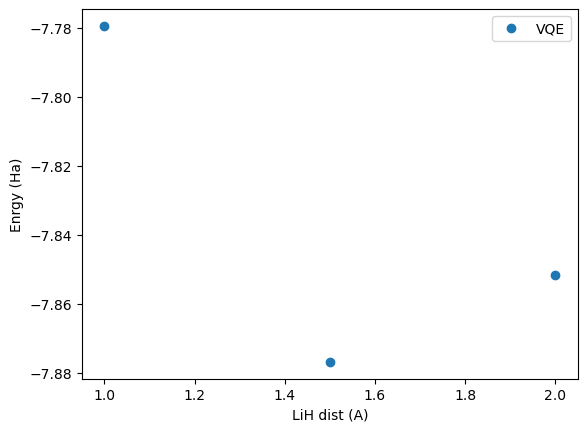

In [24]:
dist = [1.0,1.5,2.0]
plt.plot(dist, [e[0] + e[1] for e in energies], 'o', label = 'VQE')
plt.xlabel('LiH dist (A)')
plt.ylabel('Enrgy (Ha)')
plt.legend()
plt.show()

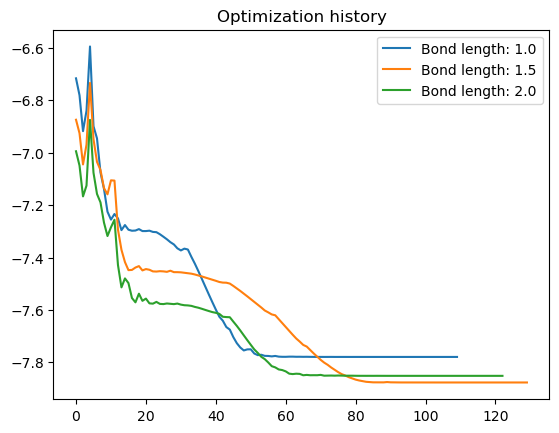

In [25]:
for i, bond_l in enumerate([1.0, 1.5, 2.0]):
    shift = energies[i][1]
    history = [h[1] + shift for h in energies[i][2]]
    plt.plot(history, label=f"Bond length: {bond_l}")

plt.title("Optimization history")
plt.legend()
plt.show()

## Extra: infrastructure

![Infrastructure](./images/diagrams_infra.png)